# Exploring Linkage Disequilibrium Data
This notebook demonstrates working with linkage disequilibrium (LD) data stored as publicly accessible BigQuery datasets.
Specifically, we will work with LD calculated on [superpopulations](http://www.1000genomes.org/faq/which-populations-are-part-your-study) of the [1000 Genomes Phase 3](http://www.nature.com/nature/journal/v526/n7571/full/nature15393.html) variants. The source variants were imported to Google Genomics and then LD calculations were performed and the resulting dataset exported to BigQuery using pipelines in the https://github.com/googlegenomics/linkage-disequilibrium project.

If you want to explore more genomics samples, see https://github.com/googlegenomics/datalab-examples. You can import them into your Datalab instance by uploading them while on the notebook list page.

In [38]:
import gcp.bigquery as bq
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [39]:
# Get references to the BigQuery tables of linkage disequilibrium
# in the five superpopulations of the 1000 Genomes Project
# (http://www.1000genomes.org/faq/which-populations-are-part-your-study):
# AMR: Admixed American
# AFR: African
# EUR: European
# SAS: South Asian
# EAS: East Asian
populations = ["AMR", "AFR", "EUR", "SAS", "EAS"]
tables = {}

for population in populations:
  tables[population] = bq.Table("genomics-pipelines:linkage_disequilibrium_1000G_phase_3.%s" % population)

tables["EUR"].length

3029459736

## Visualizing the extent of LD across populations
As the above result shows, there are over 3 billion LD results in the European dataset! That's because the 1000 Genomes Phase 3 data has over 80 million variants in it, and LD is computed between pairs of variants--even with the reduction of data stored by windowing and pruning pairs with low LD, there is still a lot of data.

The following analysis will display the total number of LD result pairs on each chromosome separately for each of the five superpopulations.

In [3]:
%%sql --module ld_count_distributions
SELECT
  qchrom,
  count(*) AS num_pairs
FROM $all_ld_table
GROUP BY qchrom

In [4]:
# Load LD result pair counts for each superpopulation and merge them into a single dataframe.
ld_counts = {}
for population, table in tables.iteritems():
  ld_counts[population] = bq.Query(ld_count_distributions,
                                   all_ld_table=table).to_dataframe()
  ld_counts[population].rename(columns={"num_pairs": population}, inplace=True)

merged_counts = None
for population in populations:
  counts = ld_counts[population]
  if merged_counts is None:
    merged_counts = counts
  else:
    merged_counts = pd.merge(merged_counts, counts, on="qchrom", how="inner")
merged_counts["qchrom"] = merged_counts["qchrom"].astype(int)
merged_counts.sort("qchrom", inplace=True)

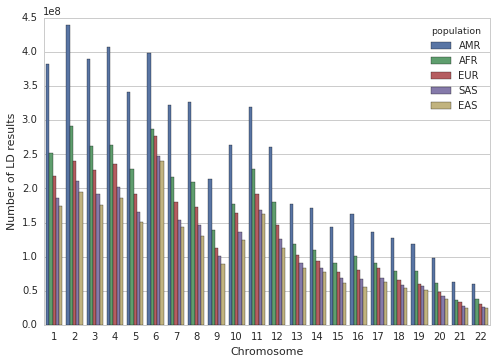

In [5]:
# Plot the LD result pair counts by chromosome and superpopulation.
melted_counts = pd.melt(merged_counts, id_vars="qchrom", var_name="population", value_name="num_results")
sns.set_style("whitegrid")
sns.barplot(x="qchrom", y="num_results", hue="population", data=melted_counts)
sns.axlabel("Chromosome", "Number of LD results")

The above results show a consistent trend, where the number of LD results per chromosome is greatest for the Admixed American superpopulation (AMR), followed by African (AFR), European (EUR), South Asian (SAS), and finally East Asian (EAS). While the presence of more LD results in AMR is expected due to population stratification ([Hinrichs et al. 2009](http://www.ncbi.nlm.nih.gov/pmc/articles/PMC3133943)), the presence of more LD in AFR than EUR is unexpected. The result likely indicates substantial population stratification within the AFR superpopulation, and a need for care in addressing it when performing association studies in a heterogeneous "African" population.

In [6]:
def merge_summary_stats(data_dict, populations=None):
  """Returns a pandas DataFrame of all summary stats for all populations.
  
  Args:
    data_dict: A dictionary keyed by population with value a DataFrame
        containing mean, stdev, and quartile information about a metric.
    populations: A list of keys of the data dictionary to include in the
        result.
        
  Returns:
    A single DataFrame with all summary statistics for all populations
        present in the input data dictionary.
  """
  if populations is None:
    populations = sorted(data_dict.keys())

  merged_dict = {"population": [],
                 "mean": [],
                 "stdev": [],
                 "min": [],
                 "max": [],
                 "q1": [],
                 "median": [],
                 "q3": []}
  
  for population in populations:
    metrics_table = data_dict[population]
    merged_dict["population"].append(population)
    merged_dict["mean"].append(metrics_table["mean"][0])
    merged_dict["stdev"].append(metrics_table["stdev"][0])
    min_, q1, median, q3, max_ = sorted(metrics_table["quantiles"])
    merged_dict["min"].append(min_)
    merged_dict["q1"].append(q1)
    merged_dict["median"].append(median)
    merged_dict["q3"].append(q3)
    merged_dict["max"].append(max_)
  
  return pd.DataFrame(merged_dict)

In [7]:
def boxplot_from_summary_stats(data, position_col, ylabel,
                               show_stddev=True, ylim=None, whis=1.5, box_width=.8):
  """Returns a boxplot based on the summary data.
  
  This function mirrors matplotlib.axes.boxplot closely, but is modified to work
  with already-summary-data rather than including the calculation of quartiles,
  mean, and standard deviation from the input data.
  """
  fig = plt.figure()
  ax = fig.add_subplot(111)
  boxes, medians, means, stds = [], [], [], []
  for pos_minus_1, row in data.iterrows():
    pos = pos_minus_1 + 1
    label = row[position_col]
    min_ = row["min"]
    q1 = row["q1"]
    median = row["median"]
    q3 = row["q3"]
    max_ = row["max"]
    mean = row["mean"]
    stdev = row["stdev"]
    iq = q3 - q1
    hi_val = q3 + whis * iq
    lo_val = q1 - whis * iq
    box_x_min = pos - box_width * 0.5
    box_x_max = pos + box_width * 0.5
    med_y = [median, median]
    med_x = [box_x_min, box_x_max]
    box_x = [box_x_min, box_x_max, box_x_max, box_x_min, box_x_min]
    box_y = [q1, q1, q3, q3, q1]
    mean_x = [pos - box_width * .05, pos + box_width * .05]
    mean_y = [mean, mean]
    std_x = [pos, pos]
    std_y = [mean - stdev, mean + stdev]
    boxes.extend(ax.plot(box_x, box_y, "b-"))
    medians.extend(ax.plot(med_x, med_y, "r-"))
    means.extend(ax.plot(mean_x, mean_y, "b-"))
    if show_stddev:
      stds.extend(ax.plot(std_x, std_y, "b--"))
  ax.set_xticklabels([""] + list(data[position_col]))
  ax.set_ylabel(ylabel)
  ax.set_axis_bgcolor("white")
  ax.grid(False)
  if ylim is not None:
    ax.set_ylim(ylim)
  return dict(boxes=boxes, medians=medians, means=means, stds=stds)

In [8]:
%%sql --module ld_rsquared_distributions
SELECT
  AVG(corr * corr) AS mean,
  STDDEV(corr * corr) AS stdev,
  QUANTILES(corr * corr, 5) AS quantiles
FROM $all_ld_table

In [9]:
%%sql --module ld_maf_distributions
SELECT
  AVG(LEAST(num_bothone_chroms,
            num_chroms - num_qone_chroms - num_tone_chroms + num_bothone_chroms,
            num_qone_chroms - num_bothone_chroms,
            num_tone_chroms - num_bothone_chroms) / num_chroms) AS mean,
  STDDEV(LEAST(num_bothone_chroms,
               num_chroms - num_qone_chroms - num_tone_chroms + num_bothone_chroms,
               num_qone_chroms - num_bothone_chroms,
               num_tone_chroms - num_bothone_chroms) / num_chroms) AS stdev,
  QUANTILES(LEAST(num_bothone_chroms,
                  num_chroms - num_qone_chroms - num_tone_chroms + num_bothone_chroms,
                  num_qone_chroms - num_bothone_chroms,
                  num_tone_chroms - num_bothone_chroms) / num_chroms, 5) AS quantiles
FROM $all_ld_table

In [10]:
# Load LD mean, stdev, and quantile results of r^2 and the frequency of bminor allele frequency for each superpopulation,
# and merge them into single dataframes.
rsquared_metrics = {}
maf_metrics = {}
for population, table in tables.iteritems():
  rsquared_metrics[population] = bq.Query(ld_rsquared_distributions,
                                          all_ld_table=table).to_dataframe()
  maf_metrics[population] = bq.Query(ld_maf_distributions,
                                     all_ld_table=table).to_dataframe()
  
merged_rsquared_metrics = merge_summary_stats(rsquared_metrics, populations)
merged_maf_metrics = merge_summary_stats(maf_metrics, populations)

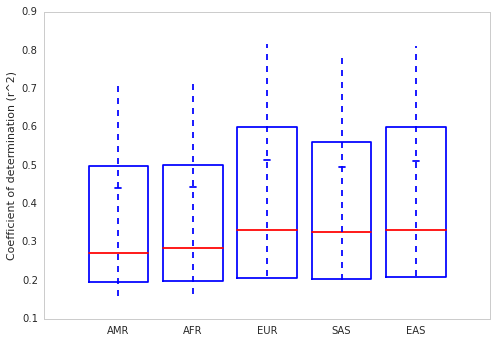

In [11]:
_ = boxplot_from_summary_stats(merged_rsquared_metrics,
                               position_col="population",
                               ylabel="Coefficient of determination (r^2)")

The boxplot of the r^2 measure of LD shows that the mean and median LD are highest for the European and East Asian superpopulations, and substantially lower for the African and Admixed American populations. This suggests that the larger total number of LD results in African and Admixed American populations (as evidenced by the barplot of LD results given above) may arise from rare haplotypes.

To investigate this hypothesis, we can examine the distribution of frequencies of the least-frequently-occurring haplotype in LD results.

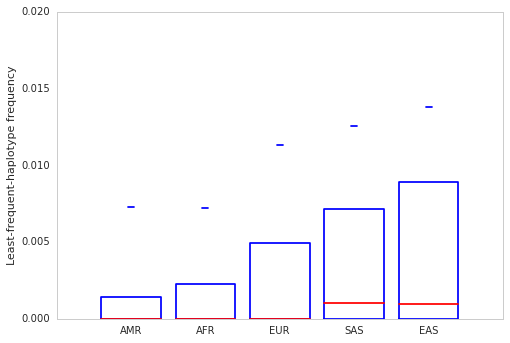

In [12]:
_ = boxplot_from_summary_stats(merged_maf_metrics,
                               position_col="population",
                               ylabel="Least-frequent-haplotype frequency",
                               show_stddev=False,
                               ylim=[0, 0.02])

The boxplots of the frequency of the least-frequently-occurring haplotypes shows that the Admixed American and African superpopulations have a similar distribution of rare haplotypes included in their LD results. The superpopulation with the distribution of least-rare haplotypes is East Asian.

## Focusing on specific subsets of all linkage disequilibrium results
Below we will load the LD results from BigQuery for specific, relatively small regions of the genome that we want to investigate more deeply.

In [24]:
# Identify genomic regions of interest.
# A random area of the genome.
random_region = ("20", 10000000, 10300000)
# An area surrounding a gene involved in lactase persistence, which was positively selected
# for in Europeans (http://www.ncbi.nlm.nih.gov/pmc/articles/PMC3048992/). 
lactase_region = ("2", 136450000, 136750000)

In [15]:
%%sql --module ld_results
SELECT
  qstart,
  tstart,
  corr * corr AS rsquared
FROM $all_ld_table
WHERE
  qchrom = $chromosome AND
  qstart < tstart AND
  qstart >= $start AND
  tstart <= $end

In [25]:
# Load LD results for each of the regions in all five superpopulations.
results = {}
for name, region in [("random", random_region),
                     ("lactase", lactase_region)]:
  chrom, start, end = region
  results[name] = {}
  for population, table in tables.iteritems():
    result = bq.Query(ld_results,
                      all_ld_table=table,
                      chromosome=chrom,
                      start=start,
                      end=end).to_dataframe()
    results[name][population] = result
  
results["lactase"]["EUR"][:5]

,qstart,tstart,rsquared
0,136500305,136724897,1.000000
1,136500474,136700023,0.581600
2,136500474,136701538,0.527865
3,136500474,136702117,0.527865
4,136500474,136702600,0.527224


The LD results we've loaded have chromosomal positions and the measure of LD. Since variants occur far from each other in physical space, it is useful to order them by their index when sorted by chromosomal position for the purposes of visualization.

In [26]:
# Find the index of each position in the output.
import pandas as pd

def add_indices(df_list):
  """Add the index of each position as an attribute of all dataframes in the list."""
  unique_positions = set()
  for df in df_list:
    unique_positions = unique_positions.union(df["qstart"]).union(df["tstart"])
  sorted_positions = sorted(unique_positions)
  indices = pd.DataFrame(range(len(sorted_positions)), index=sorted_positions)
  for df in df_list:
    df["qindex"] = list(indices.loc[df["qstart"]][0])
    df["tindex"] = list(indices.loc[df["tstart"]][0])

In [27]:
for popdict in results.values():
  add_indices(popdict.values())

The following function defines a plotting method that can be used to visualize the pairwise LD results as a triangle plot.

In [20]:
# Plot the structure of the LD data
import math
import matplotlib
import matplotlib.pyplot as plt

def plot_ld_figure(ld_dict, title=None):
  """Plots a triangle plot of LD results for a single region in multiple populations.
  
  Args:
    ld_dict: A dictionary keyed by population with value a pandas DataFrame of LD in that population.
    title: A title for the plot.
  """
  fig = plt.figure()
  
  # The colormap we use to shade LD in all subplots.
  cmap = matplotlib.cm.get_cmap("Reds")

  # The scaling we apply to variant index values to create an upward-pointing triangle plot.
  scale = 0.5
  def plot_subplot(alldata, location, population, label=False):
    """Create an LD subplot."""
    ax = fig.add_subplot(location)
  
    # Restrict to data points with positive r^2.
    data = alldata.loc[alldata["rsquared"] > 0]
    
    # Transform points from indexes to an upward-pointing triangle.
    x = (data["tindex"] + data["qindex"]) * scale
    y = (data["tindex"] - data["qindex"]) * scale

    # Plot the LD values on the scaled axes.
    hex = ax.hexbin(x, y, data["rsquared"],
                  cmap=cmap, vmin=0, vmax=1,
                  gridsize=data["qindex"].max() - data["qindex"].min() + 1)

    # Make the plot look nice.
    ax.set_aspect("equal")
    ax.set_xlim([x.min(), x.max()])
    ax.set_ylim([y.min(), y.max()])
    ax.set_axis_bgcolor("white")
    ax.grid(False)
    ax.get_yaxis().set_ticks([])
    ax.set_title(population)
    if label:
      ax.set_xlabel("Variant index")
    else:
      ax.get_xaxis().set_ticks([])
    return hex

  # Choose the plot layout depending on the number of populations to plot.
  locations = {4: 221, 5: 231, 6: 231, 7: 421}
  populations = sorted(ld_dict.keys())
  num_populations = len(populations)
  for i, pop in enumerate(populations):
    hex = plot_subplot(ld_dict[pop],
                       locations[num_populations] + i,
                       pop)
  
  if title:
    fig.suptitle(title)
    
  # Add the colorbar.
  fig.subplots_adjust(right=0.8)
  cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
  fig.colorbar(hex, cax=cbar_ax)

Visualization of a randomly-chosen region (a 300 kb section of chr20) shows a representative LD structure. As expected, there are small neighborhoods of strong LD (the short red triangles) but little evidence of long-range interactions, with only the Admixed American population exhibiting any appreciable LD across the entire region (likely due to population stratification).

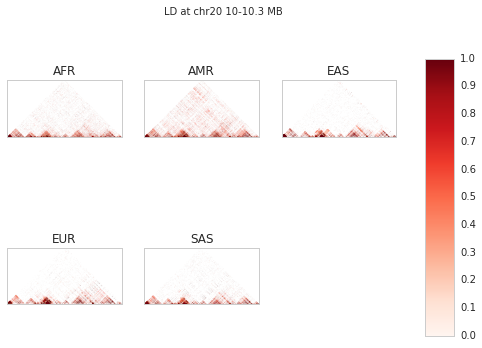

In [21]:
plot_ld_figure(results["random"], "LD at chr20 10-10.3 MB")

In stark contrast, the region surrounding the LCT and MCM6 genes, which is a region that has experienced positive selection for its ability to confer lactase persistence, shows evidence of substantial long-range LD. This is visually depicted by the large red triangle in the superpopulation-based LD plots of the region. 

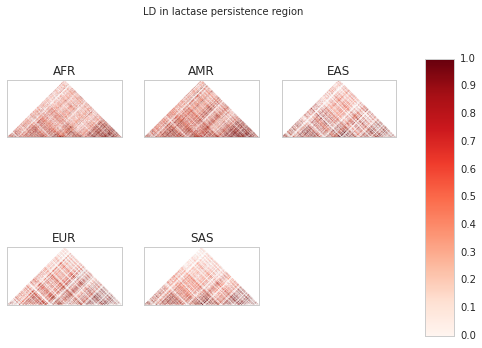

In [29]:
plot_ld_figure(results["lactase"], "LD in lactase persistence region")

Interestingly, all populations display a markedly different pattern of LD in the lactase persistence region than in the randomly-selected region of chromosome 20, not just the European population in which the lactase persistence allele has swept to high frequency.

To investigate the phenomenon more deeply, and understand whether the presence of LD in this region is attributable predominantly to selection or population stratification, we calculated linkage disequilibrium results in the lactase persistence region separately for [the subpopulations](http://www.1000genomes.org/faq/which-populations-are-part-your-study) that comprise the European and African superpopulations using the [linkage disequilibrium Dataflow pipeline](https://github.com/googlegenomics/linkage-disequilibrium#linkage-disequilibrium-calculation-pipeline).

In [30]:
subpopulations = {
  "AFR": ["ACB", "ASW", "ESN", "GWD", "LWK", "MSL", "YRI"],
  "EUR": ["CEU", "FIN", "GBR", "IBS", "TSI"]
}

subpop_ld_tables = {}
for superpopulation, subpops in subpopulations.iteritems():
  subpop_ld_tables[superpopulation] = {}
  for subpop in subpops:
    subpop_ld_tables[superpopulation][subpop] = bq.Table(
      "genomics-pipelines:linkage_disequilibrium_1000G_phase_3.lactase_sub_%s" % subpop)

In [ ]:
# Lactase region results for all African and European subpopulations.
subpop_lactase = {}
chrom, start, end = lactase_region
for superpop, subpopdict in subpop_ld_tables.iteritems():
  subpop_lactase[superpop] = {}
  for subpop, table in subpopdict.iteritems():
    result = bq.Query(ld_results,
                      all_ld_table=table,
                      chromosome=chrom,
                      start=start,
                      end=end).to_dataframe()
    subpop_lactase[superpop][subpop] = result

In [32]:
for subpopdict in subpop_lactase.values():
  add_indices(subpopdict.values())

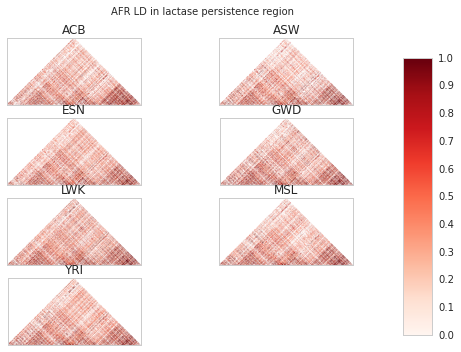

In [35]:
plot_ld_figure(subpop_lactase["AFR"], "AFR LD in lactase persistence region")

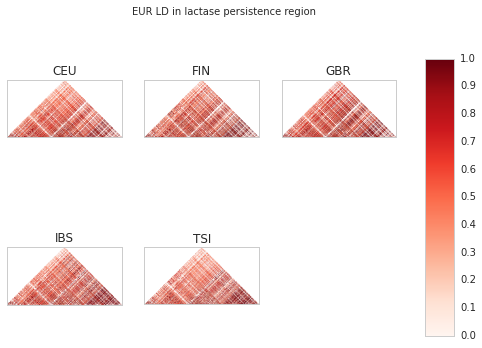

In [34]:
plot_ld_figure(subpop_lactase["EUR"], "EUR LD in lactase persistence region")

The LD results in the lactase persistence region are visibly less intense in the African subpopulations than in the European subpopulations, as is expected given the evidence for strong positive selection in Europeans in the region.

## Linkage disequilibrium decay
We can also investigate the extent to which linkage disequilibrium decays as a function of distance between variants, in a manner similar to that performed in [Extended Data Figure 10](http://www.nature.com/nature/journal/v526/n7571/fig_tab/nature15393_SF10.html) of the [1000 Genomes Phase 3](http://www.nature.com/nature/journal/v526/n7571/full/nature15393.html) paper.

In [40]:
%%sql --module ld_decay
SELECT
  distance,
  count(*) AS num_chroms,
  SUM(rsquared) AS sum_rsquared,
  STDDEV_SAMP(rsquared) AS stdev_rsquared
FROM
  (SELECT
     CEIL((tstart - qstart) / $bin_size) AS distance,
     corr * corr AS rsquared
   FROM $all_ld_table
   WHERE qstart < tstart)
GROUP BY distance
ORDER BY distance

In [42]:
# Create a dictionary keyed by population with value a DataFrame of r^2 values
# binned by distance from the query variant.
decay = {}
bin_size = 5000
for population, table in tables.iteritems():
  result = bq.Query(ld_decay,
                    all_ld_table=table,
                    bin_size=bin_size).to_dataframe()
  result["mean_rsquared"] = result["sum_rsquared"] / result["num_chroms"]
  result["distance"] *= bin_size
  decay[population] = result.loc[result["distance"] <= 1000000]

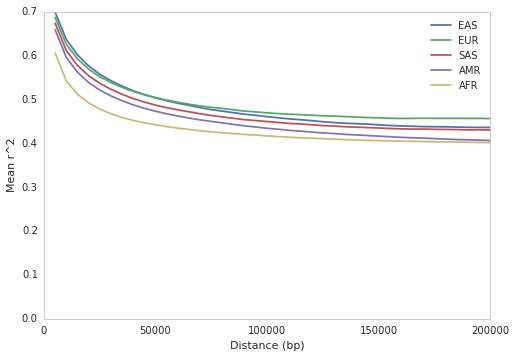

In [56]:
fig = plt.figure()
ax = fig.add_subplot(111)
handles = []
populations = [k for k, v in sorted(decay.items(),
                                    key=lambda x: max(x[1]["mean_rsquared"]),
                                    reverse=True)]
max_distance = 200000

for population in populations:
  df = decay[population]
  df = df.loc[df["distance"] <= max_distance]
  lp, = ax.plot(df["distance"], df["mean_rsquared"],
                label=population)
  handles.append(lp)
plt.legend(handles, populations)
ax.set_axis_bgcolor("white")
ax.grid(False)
ax.set_ylim(0)
ax.set_xlabel("Distance (bp)")
_ = ax.set_ylabel("Mean r^2")

The plots show a decay of LD strength as distance between variants increases. However, the curves plateau at an r^2 minimum between 0.4 and 0.5.

The reason this looks very different from the 1000 Genomes LD decay is that this plot is calculating average LD decay between pairs but is restricting to only pairs for which r^2 >= 0.16. To investigate an unbiased pattern of LD decay, we created additional data sets of linkage disequilibrium without any LD strength restrictions within the lactase persistence region of chromosome 2 using the [linkage disequilibrium Dataflow pipeline](https://github.com/googlegenomics/linkage-disequilibrium#linkage-disequilibrium-calculation-pipeline).

In [68]:
%%sql --module ld_decay_in_region
SELECT
  distance,
  count(*) AS num_chroms,
  SUM(rsquared) AS sum_rsquared,
  STDDEV_SAMP(rsquared) AS stdev_rsquared
FROM
  (SELECT
     CEIL((tstart - qstart) / $bin_size) AS distance,
     corr * corr AS rsquared
   FROM $all_ld_table
   WHERE qstart < tstart AND
         qchrom = $chrom AND
         qstart >= $start AND
         tstart <= $end)
GROUP BY distance
ORDER BY distance

In [77]:
lchrom, lstart, lend = ("2", 136100000, 137100000)  # An extended region around LCT
lactase_ld_decay = {}
bin_size = 5000
lactase_tables = {}

# Load the BigQuery tables surrounding the lactase region with no correlation cutoff threshold.
for population in populations:
  lactase_tables[population] = bq.Table("genomics-pipelines:linkage_disequilibrium_1000G_phase_3.lactase_%s" % population)

# Run the queries to calculate binned r^2 values
for population, table in lactase_tables.iteritems():
  result = bq.Query(ld_decay_in_region,
                    all_ld_table=table,
                    bin_size=bin_size,
                    chrom=lchrom,
                    start=lstart,
                    end=lend).to_dataframe()
  result["distance"] *= bin_size
  result["mean_rsquared"] = result["sum_rsquared"] / result["num_chroms"]
  lactase_ld_decay[population] = result

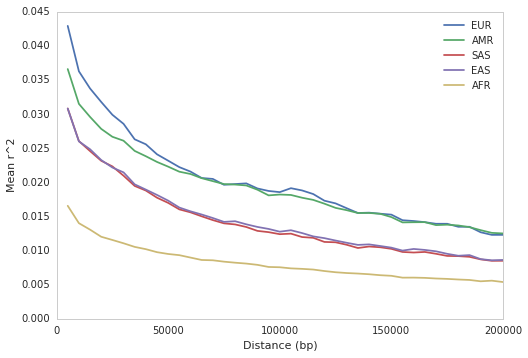

In [79]:
fig = plt.figure()
ax = fig.add_subplot(111)
handles = []
populations = [k for k, v in sorted(lactase_ld_decay.items(),
                                    key=lambda x: x[1]["mean_rsquared"].max(),
                                    reverse=True)]
max_distance = 200000

for population in populations:
  df = lactase_ld_decay[population]
  df = df.loc[df["distance"] <= max_distance]
  lp, = ax.plot(df["distance"], df["mean_rsquared"],
                label=population)
  handles.append(lp)
plt.legend(handles, populations)
ax.set_axis_bgcolor("white")
ax.grid(False)
ax.set_ylim(0)
ax.set_xlabel("Distance (bp)")
_ = ax.set_ylabel("Mean r^2")

Unbiased LD results show patterns of LD decay consistent with expectations for the lactase persistence region, with LD decaying as distance from the query variant increases and the most LD present in Europeans.